# 🧭 Conteo único de personas con RF‑DETR y DeepSORT

Notebook paso a paso para:

- Montar Google Drive y leer un video en `/dataset/videos/`
- Dividir el video en segmentos de 1 minuto y extraer frames
- Detectar personas con RF‑DETR (o DETR de respaldo)
- Hacer tracking / Re‑ID con DeepSORT para conteo único
- Guardar resultados (frames anotados + CSV) en `/dataset/results/`

Una vez confirmadas las etiquetas, si el ID 1 corresponde a 'person' y aún se cuentan objetos que no son personas, podemos intentar aumentar el `conf_threshold` (umbral de confianza) en la función `process_video_pipeline` para filtrar las detecciones menos confiables.

In [13]:
# @title 1. Configuración del Entorno e Instalación
import os
import sys
from google.colab import drive

# 1.1 Montar Google Drive
drive.mount('/content/drive')

# 1.2 Definir Rutas (Ajusta si es necesario)
BASE_DIR = '/content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2'
VIDEO_DIR = os.path.join(BASE_DIR, 'Dataset/muestra')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Crear directorios si no existen
os.makedirs(RESULTS_DIR, exist_ok=True)
CROPS_DIR = os.path.join(RESULTS_DIR, 'crops')
os.makedirs(CROPS_DIR, exist_ok=True)

print(f"📂 Directorio de Videos: {VIDEO_DIR}")
print(f"📂 Directorio de Resultados: {RESULTS_DIR}")

# 1.3 Instalar Dependencias Críticas
print("⬇️ Instalando librerías de Tracking y Detección...")
!pip install -q deep-sort-realtime
!pip install -q transformers
!pip install -q ultralytics
!pip install -q supervision  # Útil para visualización avanzada

import torch
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import shutil

# Verificar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Entorno listo. Usando dispositivo: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Directorio de Videos: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/Dataset/muestra
📂 Directorio de Resultados: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results
⬇️ Instalando librerías de Tracking y Detección...
✅ Entorno listo. Usando dispositivo: cuda


In [ ]:
# @title 2.🎥 Carga del Modelo de Detección (RF-DETR / Fallback)
from transformers import DetrImageProcessor, DetrForObjectDetection

# Configuración de modelos
MODEL_NAME_RF = 'roboflow/rf_detr'  # Modelo privado/custom
MODEL_NAME_DETR = 'facebook/detr-resnet-50' # Fallback público

print('🔄 Cargando modelo...')

processor = None
model = None

try:
    # Intentar cargar RF-DETR
    processor = DetrImageProcessor.from_pretrained(MODEL_NAME_RF)
    model = DetrForObjectDetection.from_pretrained(MODEL_NAME_RF).to(device)
    print(f'✅ RF-DETR cargado exitosamente: {MODEL_NAME_RF}')
except Exception as e:
    print(f'⚠️ No se pudo cargar RF-DETR ({e}).')
    print(f'🔄 Cargando modelo de respaldo: {MODEL_NAME_DETR}...')
    try:
        processor = DetrImageProcessor.from_pretrained(MODEL_NAME_DETR)
        model = DetrForObjectDetection.from_pretrained(MODEL_NAME_DETR).to(device)
        print(f'✅ Modelo de respaldo cargado: {MODEL_NAME_DETR}')
    except Exception as e_fallback:
        print(f'❌ Error crítico cargando el modelo de respaldo: {e_fallback}')
        raise e_fallback

model.eval()
print("🤖 Modelo listo para inferencia.")

🔄 Cargando modelo...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


⚠️ No se pudo cargar RF-DETR (roboflow/rf_detr is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`).
🔄 Cargando modelo de respaldo: facebook/detr-resnet-50...


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

✅ Modelo de respaldo cargado: facebook/detr-resnet-50
🤖 Modelo listo para inferencia.


In [ ]:
# @title 3. Funciones de Utilidad (Crops)

def save_person_crop(frame, bbox, person_id, frame_idx, save_dir):
    """
    Recorta y guarda la imagen de la persona detectada.
    Organiza los archivos en carpetas por ID: /crops/ID_1/frame_001.jpg
    """
    try:
        # bbox viene en formato [left, top, right, bottom]
        l, t, r, b = map(int, bbox)
        h_img, w_img, _ = frame.shape

        # Asegurar que las coordenadas estén dentro de la imagen (Clamping)
        l = max(0, l)
        t = max(0, t)
        r = min(w_img, r)
        b = min(h_img, b)

        # Validar que el recorte tenga tamaño > 0
        if r <= l or b <= t:
            return

        # Extraer recorte
        crop = frame[t:b, l:r]

        if crop.size == 0:
            return

        # Crear carpeta para este ID específico
        person_dir = os.path.join(save_dir, str(person_id))
        os.makedirs(person_dir, exist_ok=True)

        # Nombre del archivo: id_XXXX_frame_YYYYYY.jpg
        filename = f"id_{person_id}_frame_{frame_idx:06d}.jpg"
        save_path = os.path.join(person_dir, filename)

        # Guardar (cv2 usa BGR, el frame ya viene en BGR desde opencv)
        cv2.imwrite(save_path, crop)

    except Exception as e:
        print(f"⚠️ Error guardando crop para ID {person_id}: {e}")

def get_video_files(directory):
    """Busca archivos de video soportados en el directorio."""
    if not os.path.exists(directory):
        return []
    exts = ('.mp4', '.mov', '.avi', '.mkv')
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(exts)]

In [ ]:
# @title 4. Pipeline de Procesamiento (Detección + Tracking + Crops)
from deep_sort_realtime.deepsort_tracker import DeepSort

def process_video_pipeline(video_path, model, processor, output_dir, conf_threshold=0.7, skip_frames=2):
    """
    Pipeline completo:
    1. Lee el video como stream.
    2. Detecta personas con DETR.
    3. Asigna IDs únicos con DeepSORT.
    4. Guarda crops y metadatos.
    """

    # Configuración de salida
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    video_crops_dir = os.path.join(output_dir, 'crops', video_name) # Subcarpeta por video
    csv_path = os.path.join(output_dir, f'{video_name}_tracking_data.csv')
    os.makedirs(video_crops_dir, exist_ok=True)

    # Inicializar Video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: No se pudo abrir {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Inicializar DeepSORT
    # max_age=30: Si se pierde el rastro por 30 frames, se olvida el ID.
    # n_init=3: Necesita 3 detecciones consecutivas para confirmar un ID.
    tracker = DeepSort(max_age=200, n_init=1, nms_max_overlap=1.0,
                       max_iou_distance=0.98, embedder='mobilenet',
                       embedder_gpu=torch.cuda.is_available())

    tracking_data = []
    unique_ids_found = set()

    print(f"▶️ Procesando: {video_name}")
    print(f"   - FPS: {fps:.2f}, Total Frames: {total_frames}")
    print(f"   - Skip Frames: {skip_frames} (Procesando 1 de cada {skip_frames+1})")

    frame_idx = 0
    pbar = tqdm(total=total_frames, unit='frame')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Lógica de salto de frames para acelerar (DeepSORT tolera pequeños saltos)
        if frame_idx % (skip_frames + 1) != 0:
            frame_idx += 1
            pbar.update(1)
            continue

        # --- 1. Inferencia DETR ---
        # Convertir a RGB y PIL para el modelo
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        inputs = processor(images=pil_image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # Post-procesamiento para obtener cajas [x1, y1, x2, y2]
        target_sizes = torch.tensor([pil_image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=conf_threshold)[0]

        # --- 2. Preparar Detecciones para DeepSORT ---
        # DeepSORT espera: [[left, top, w, h], confidence, class_name]
        detections_for_tracker = []

        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            # Verificar ID de clase 'person' (COCO id 1 es persona en DETR estándar)
            # Si usas un modelo custom, verifica el ID. DETR facebook usa 1 para persona.
            if label.item() == 1:
                x1, y1, x2, y2 = box.tolist()
                w = x2 - x1
                h = y2 - y1
                detections_for_tracker.append(([x1, y1, w, h], float(score), 'person'))

        # --- 3. Actualizar Tracker ---
        tracks = tracker.update_tracks(detections_for_tracker, frame=frame)

        # --- 4. Procesar Tracks Confirmados ---
        for track in tracks:
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            unique_ids_found.add(track_id)

            # Obtener BBox en formato LTRB (Left, Top, Right, Bottom)
            ltrb = track.to_ltrb()

            # Guardar Crop (Recorte)
            save_person_crop(frame, ltrb, track_id, frame_idx, video_crops_dir)

            # Guardar Metadatos
            tracking_data.append({
                'video': video_name,
                'frame': frame_idx,
                'time_sec': frame_idx / fps,
                'person_id': track_id,
                'bbox_x1': ltrb[0],
                'bbox_y1': ltrb[1],
                'bbox_x2': ltrb[2],
                'bbox_y2': ltrb[3]
            })

        frame_idx += 1
        pbar.update(1)

    cap.release()
    pbar.close()

    # Guardar CSV
    if tracking_data:
        df = pd.DataFrame(tracking_data)
        df.to_csv(csv_path, index=False)
        print(f"✅ Procesamiento finalizado.")
        print(f"   - Personas únicas detectadas: {len(unique_ids_found)}")
        print(f"   - Datos guardados en: {csv_path}")
        print(f"   - Recortes guardados en: {video_crops_dir}")
        return df
    else:
        print("⚠️ No se detectaron personas o tracks confirmados.")
        return pd.DataFrame()

In [ ]:
def process_video_person_count(video_path, model, processor, output_dir, conf_threshold=0.7, skip_frames=2):
    """
    Pipeline simplificado para contar todas las personas presentes en el frame (sin tracking).
    1. Lee el video como stream.
    2. Detecta personas con DETR.
    3. Cuenta el número de personas detectadas por frame.
    """

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    csv_path = os.path.join(output_dir, f'{video_name}_total_person_count_per_frame.csv')

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: No se pudo abrir {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    person_count_data = []

    print(f"▶️ Procesando para conteo total de personas: {video_name}")
    print(f"   - FPS original: {fps:.2f}, Total Frames: {total_frames}")
    print(f"   - Skip Frames: {skip_frames} (Procesando 1 de cada {skip_frames+1})")

    frame_idx = 0
    pbar = tqdm(total=total_frames, unit='frame')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Lógica de salto de frames para acelerar
        if frame_idx % (skip_frames + 1) != 0:
            frame_idx += 1
            pbar.update(1)
            continue

        # --- 1. Inferencia DETR ---
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        inputs = processor(images=pil_image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([pil_image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=conf_threshold)[0]

        # --- 2. Contar personas ---
        persons_in_frame = 0

        for label in results["labels"]:
            if label.item() == 1: # Asumiendo que el ID de COCO 1 es 'person'
                persons_in_frame += 1

        person_count_data.append({
            'video': video_name,
            'frame': frame_idx,
            'time_sec': frame_idx / fps,
            'total_persons_detected': persons_in_frame
        })

        frame_idx += 1
        pbar.update(1)

    cap.release()
    pbar.close()

    if person_count_data:
        df_person_counts = pd.DataFrame(person_count_data)
        df_person_counts.to_csv(csv_path, index=False)
        print(f"✅ Conteo de personas por frame finalizado.")
        print(f"   - Datos de conteo guardados en: {csv_path}")
        return df_person_counts
    else:
        print("⚠️ No se detectaron personas en el video.")
        return pd.DataFrame()


In [21]:
videos = get_video_files(VIDEO_DIR)
target_video = videos[0] # Tomamos el primero como ejemplo
print(f"🎬 Iniciando análisis para: {target_video}")

🎬 Iniciando análisis para: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/Dataset/muestra/Muestra2.mp4


In [ ]:
print('Clases detectadas por el modelo:')
if hasattr(model.config, 'id2label'):
    for k, v in model.config.id2label.items():
        print(f"ID: {k}, Label: {v}")
else:
    print("No se encontraron etiquetas de clase en la configuración del modelo.")


Clases detectadas por el modelo:
ID: 0, Label: N/A
ID: 1, Label: person
ID: 10, Label: traffic light
ID: 11, Label: fire hydrant
ID: 12, Label: street sign
ID: 13, Label: stop sign
ID: 14, Label: parking meter
ID: 15, Label: bench
ID: 16, Label: bird
ID: 17, Label: cat
ID: 18, Label: dog
ID: 19, Label: horse
ID: 2, Label: bicycle
ID: 20, Label: sheep
ID: 21, Label: cow
ID: 22, Label: elephant
ID: 23, Label: bear
ID: 24, Label: zebra
ID: 25, Label: giraffe
ID: 26, Label: hat
ID: 27, Label: backpack
ID: 28, Label: umbrella
ID: 29, Label: shoe
ID: 3, Label: car
ID: 30, Label: eye glasses
ID: 31, Label: handbag
ID: 32, Label: tie
ID: 33, Label: suitcase
ID: 34, Label: frisbee
ID: 35, Label: skis
ID: 36, Label: snowboard
ID: 37, Label: sports ball
ID: 38, Label: kite
ID: 39, Label: baseball bat
ID: 4, Label: motorcycle
ID: 40, Label: baseball glove
ID: 41, Label: skateboard
ID: 42, Label: surfboard
ID: 43, Label: tennis racket
ID: 44, Label: bottle
ID: 45, Label: plate
ID: 46, Label: wine g

In [24]:
# @title 5. Ejecutar Análisis en Video
# Buscar videos
videos = get_video_files(VIDEO_DIR)

if videos:
    target_video = videos[0] # Tomamos el primero como ejemplo
    print(f"🎬 Iniciando análisis para: {target_video}")

    # Obtener FPS del video para calcular skip_frames
    cap_temp = cv2.VideoCapture(target_video)
    fps = cap_temp.get(cv2.CAP_PROP_FPS)
    cap_temp.release()

    # Calcular skip_frames para procesar 1 frame cada 2 segundos
    # En 2 segundos, hay (fps * 2) frames. Si procesamos 1, saltamos (fps * 2) - 1.
    # Asegurarse de que skip_frames sea al menos 0
    skip_frames_for_2_sec = max(0, int(fps * 2) - 1)
    print(f"   - FPS del video: {fps:.2f}")
    print(f"   - Ajustando para procesar 1 frame cada 2 segundos, skip_frames = {skip_frames_for_2_sec}")

    # EJECUCIÓN
    # skip_frames=N procesa 1 de cada (N+1) frames.
    df_results = process_video_pipeline(
        target_video,
        model,
        processor,
        RESULTS_DIR,
        conf_threshold=0.98,
        skip_frames=skip_frames_for_2_sec # Se ajusta dinámicamente
    )

else:
    print(f"❌ No se encontraron videos en {VIDEO_DIR}")

🎬 Iniciando análisis para: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/Dataset/muestra/Muestra2.mp4
   - FPS del video: 30.00
   - Ajustando para procesar 1 frame cada 2 segundos, skip_frames = 59
▶️ Procesando: Muestra2
   - FPS: 30.00, Total Frames: 9030
   - Skip Frames: 59 (Procesando 1 de cada 60)


  0%|          | 0/9030 [00:00<?, ?frame/s]

✅ Procesamiento finalizado.
   - Personas únicas detectadas: 10
   - Datos guardados en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/Muestra2_tracking_data.csv
   - Recortes guardados en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/crops/Muestra2



📊 Primeras 5 filas del dataset de tracking:


,video,frame,time_sec,person_id,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,Muestra2,60,2.0,1,383.218159,831.084009,594.623966,1039.464026
1,Muestra2,60,2.0,2,707.038428,513.737621,863.236066,655.122755
2,Muestra2,120,4.0,1,374.368509,819.436277,594.481709,1036.830770
3,Muestra2,120,4.0,2,707.041591,512.913975,865.644387,656.552285
4,Muestra2,180,6.0,1,373.574715,817.688150,593.691594,1035.509984



👥 Conteo Total de IDs únicos: 10


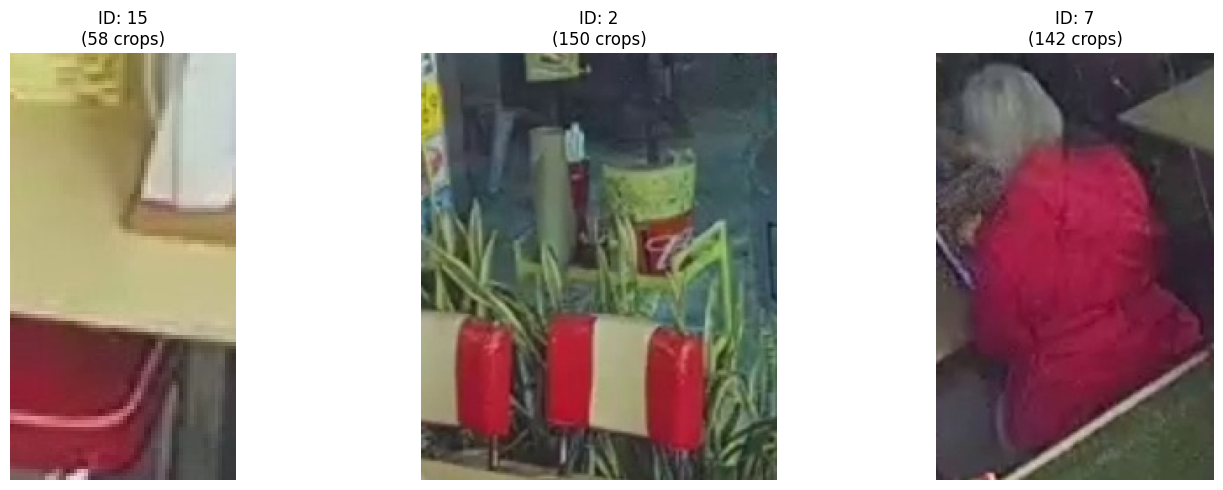

In [25]:
# @title 6. Visualización de Resultados (CSV y Crops)
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

if 'df_results' in globals() and not df_results.empty:
    # 1. Mostrar tabla resumen
    print("\n📊 Primeras 5 filas del dataset de tracking:")
    display(df_results.head())

    print("\n👥 Conteo Total de IDs únicos:", df_results['person_id'].nunique())

    # 2. Mostrar ejemplos de Crops
    video_name = df_results['video'].iloc[0]
    crops_root = os.path.join(RESULTS_DIR, 'crops', video_name)

    # Obtener IDs disponibles
    person_ids = [d for d in os.listdir(crops_root) if os.path.isdir(os.path.join(crops_root, d))]

    if person_ids:
        # Seleccionar hasta 3 personas aleatorias
        selected_ids = random.sample(person_ids, min(3, len(person_ids)))

        plt.figure(figsize=(15, 5))
        plot_idx = 1

        for pid in selected_ids:
            # Buscar imágenes de esa persona
            p_dir = os.path.join(crops_root, pid)
            images = sorted(glob.glob(os.path.join(p_dir, "*.jpg")))

            if images:
                # Mostrar la primera imagen de cada ID seleccionado
                img = mpimg.imread(images[len(images)//2]) # Imagen central del track
                plt.subplot(1, 3, plot_idx)
                plt.imshow(img)
                plt.title(f"ID: {pid}\n({len(images)} crops)")
                plt.axis('off')
                plot_idx += 1

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se encontraron carpetas de crops.")

else:
    print("⚠️ No hay resultados para visualizar.")

In [26]:
unique_persons_per_frame = df_results.groupby('time_sec')['person_id'].nunique()
print("Número de personas únicas por frame:")
print(unique_persons_per_frame.head())

Número de personas únicas por frame:
time_sec
2.0     2
4.0     2
6.0     2
8.0     3
10.0    3
Name: person_id, dtype: int64


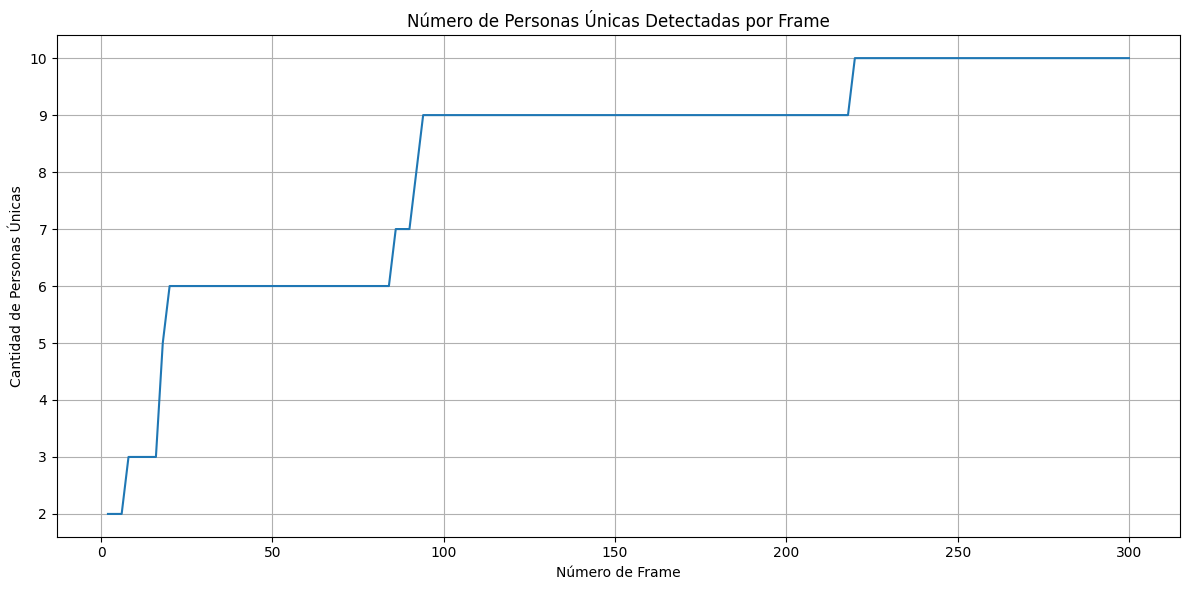

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(unique_persons_per_frame.index, unique_persons_per_frame.values)
plt.title('Número de Personas Únicas Detectadas por Frame')
plt.xlabel('Número de Frame')
plt.ylabel('Cantidad de Personas Únicas')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
print(unique_persons_per_frame)

time_sec
2.0       2
4.0       2
6.0       2
8.0       3
10.0      3
         ..
292.0    10
294.0    10
296.0    10
298.0    10
300.0    10
Name: person_id, Length: 150, dtype: int64


In [29]:
# Guardar unique_persons_per_frame en un CSV
csv_output_path = os.path.join(RESULTS_DIR, 'unique_persons_per_frame.csv')
unique_persons_per_frame.to_csv(csv_output_path, header=True, index=True, index_label='time_sec')
print(f"CSV con el conteo de personas únicas por frame guardado en: {csv_output_path}")

CSV con el conteo de personas únicas por frame guardado en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/unique_persons_per_frame.csv


▶️ Procesando para conteo total de personas: Muestra2
   - FPS original: 30.00, Total Frames: 9030
   - Skip Frames: 59 (Procesando 1 de cada 60)


  0%|          | 0/9030 [00:00<?, ?frame/s]

✅ Conteo de personas por frame finalizado.
   - Datos de conteo guardados en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/Muestra2_total_person_count_per_frame.csv

📊 Primeras 5 filas del dataset de conteo total por frame:


,video,frame,time_sec,total_persons_detected
0,Muestra2,0,0.0,5
1,Muestra2,60,2.0,7
2,Muestra2,120,4.0,5
3,Muestra2,180,6.0,7
4,Muestra2,240,8.0,5


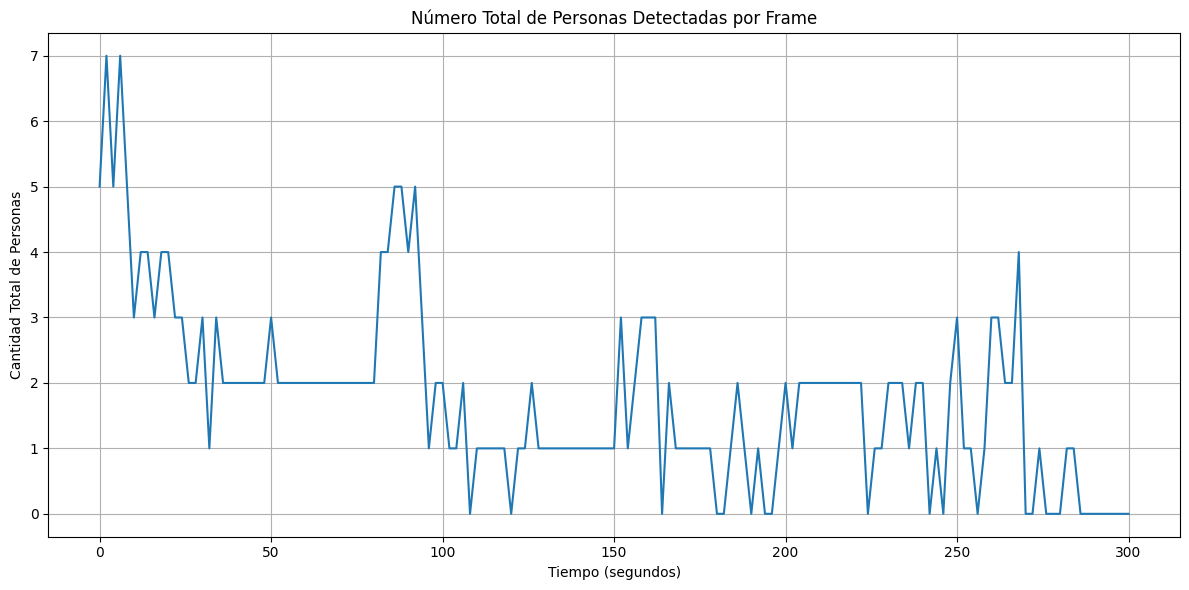

In [30]:
# Obtener FPS del video para calcular skip_frames
cap_temp = cv2.VideoCapture(target_video)
fps = cap_temp.get(cv2.CAP_PROP_FPS)
cap_temp.release()
skip_frames_for_2_sec = max(0, int(fps * 2) - 1)
# Ejecutar la función para el conteo total de personas por frame
df_person_counts = process_video_person_count(
    target_video,
    model,
    processor,
    RESULTS_DIR,
    conf_threshold=0.8,
    skip_frames=skip_frames_for_2_sec
)

if not df_person_counts.empty:
    # 1. Mostrar las primeras filas del dataset de conteo
    print("\n📊 Primeras 5 filas del dataset de conteo total por frame:")
    display(df_person_counts.head())

    # 2. Generar la gráfica del conteo total de personas por frame
    plt.figure(figsize=(12, 6))
    plt.plot(df_person_counts['time_sec'], df_person_counts['total_persons_detected'])
    plt.title('Número Total de Personas Detectadas por Frame')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Cantidad Total de Personas')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Guardar el DataFrame a CSV (esto ya se hace dentro de la función, pero lo muestro como ejemplo)
    # csv_output_path_total = os.path.join(RESULTS_DIR, f'{video_name}_total_person_count_per_frame.csv')
    # df_person_counts.to_csv(csv_output_path_total, index=False)
    # print(f"CSV con el conteo total de personas por frame guardado en: {csv_output_path_total}")
else:
    print("⚠️ No se generaron datos de conteo total de personas.")

In [22]:
import cv2
import os
import torch
from PIL import Image
from tqdm.auto import tqdm

def process_video_pipeline_box(video_path, model, processor, output_dir, conf_threshold=0.7, skip_frames=2):
    """
    Procesa un video para detectar personas, dibujar bounding boxes en los frames
    y guardar estos frames anotados en un directorio especificado.

    Args:
        video_path (str): Ruta al archivo de video de entrada.
        model: Modelo de detección (DETR).
        processor: Procesador de imágenes para el modelo DETR.
        output_dir (str): Directorio donde se guardarán los frames anotados.
        conf_threshold (float): Umbral de confianza para las detecciones.
        skip_frames (int): Número de frames a saltar entre cada procesamiento.
    """

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    annotated_frames_dir = os.path.join(output_dir, 'frames_with_boxes', video_name)
    os.makedirs(annotated_frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: No se pudo abrir {video_path}")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(f"▶️ Iniciando detección y guardado de frames anotados para: {video_name}")
    print(f"   - FPS original: {fps:.2f}, Total Frames: {total_frames}")
    print(f"   - Skip Frames: {skip_frames} (Procesando 1 de cada {skip_frames+1})")
    print(f"   - Frames anotados se guardarán en: {annotated_frames_dir}")

    frame_idx = 0
    pbar = tqdm(total=total_frames, unit='frame')

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        current_frame_for_display = frame.copy()

        if frame_idx % (skip_frames + 1) != 0:
            frame_idx += 1
            pbar.update(1)
            continue

        # --- 1. Inferencia DETR ---
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        inputs = processor(images=pil_image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([pil_image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=conf_threshold)[0]

        # --- 2. Anotar detecciones ---
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            if label.item() == 1: # Asumiendo que el ID de COCO 1 es 'person'
                x1, y1, x2, y2 = box.tolist()
                l, t, r, b = map(int, [x1, y1, x2, y2])

                # Dibujar bounding box
                color = (0, 255, 0) # Verde BGR
                cv2.rectangle(current_frame_for_display, (l, t), (r, b), color, 2)

                # Dibujar texto de la puntuación (opcional, pero útil para depurar)
                text = f"{score:.2f}"
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.6
                font_thickness = 1
                text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
                text_y = max(0, t - 5)
                cv2.putText(current_frame_for_display, text, (l, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)

        # Guardar el frame anotado
        frame_filename = os.path.join(annotated_frames_dir, f"frame_{frame_idx:06d}.jpg")
        cv2.imwrite(frame_filename, current_frame_for_display)

        frame_idx += 1
        pbar.update(1)

    cap.release()
    pbar.close()
    print(f"✅ Detección y guardado de frames finalizado. Frames guardados en: {annotated_frames_dir}")


In [23]:
# Definir la ruta para la carpeta donde se guardarán los frames anotados
ANNOTATED_FRAMES_DIR_BOX = os.path.join(RESULTS_DIR, 'frames_with_boxes')

print(f"🎬 Iniciando el proceso de detección y guardado de frames con bounding boxes para: {target_video}")

process_video_pipeline_box(
    target_video,
    model,
    processor,
    RESULTS_DIR,
    conf_threshold=0.8,
    skip_frames=skip_frames_for_2_sec
)

print(f"✅ Todos los frames con bounding boxes se han guardado en: {ANNOTATED_FRAMES_DIR_BOX}")


🎬 Iniciando el proceso de detección y guardado de frames con bounding boxes para: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/Dataset/muestra/Muestra2.mp4
▶️ Iniciando detección y guardado de frames anotados para: Muestra2
   - FPS original: 30.00, Total Frames: 9030
   - Skip Frames: 59 (Procesando 1 de cada 60)
   - Frames anotados se guardarán en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/frames_with_boxes/Muestra2


  0%|          | 0/9030 [00:00<?, ?frame/s]

✅ Detección y guardado de frames finalizado. Frames guardados en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/frames_with_boxes/Muestra2
✅ Todos los frames con bounding boxes se han guardado en: /content/drive/MyDrive/MS_INTELIGENCIA/Semestre2/Proyecto_2/results/frames_with_boxes
